# In The Kitchen, Jets Twistin Like a Stir Fry

Does it help if we rotate jets or anything?

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import roc_curve

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
n_events = len(events)
print(n_events)

308955


Get jet locations, tag, truth

In [4]:
pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
E = events["resolved_lv"].E
tag = events["tag"] # tag[index] = [1, 1, 1, 0, 0, ...] (len >= 4)
truth = events["truth"]

Then prepare for keras stuff

In [5]:
cutoff = 10
padding_val = 0

# cut off and pad
# cutoff+1 so we can have a no-4th-jet option as last index
padded_true = pad_sequences(truth,padding='post')[:,:cutoff+1]
padded_tag = pad_sequences(tag, padding='post')[:,:cutoff+1]
padded_pt = pad_sequences(pt, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_eta = pad_sequences(eta, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_phi = pad_sequences(phi, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_E = pad_sequences(E, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]

In [6]:
# 1 = should have been tagged but wasn't. 0 = correctly tagged (or not tagged)
untagged = np.logical_xor(padded_true, padded_tag).astype(int)

# n_untagged[i] = number of untagged real jets in i-th event
# We want to consider only the cases where the 3 jets are correctly tagged,
# so we have take n_untagged == 1
n_untagged = np.count_nonzero(untagged, axis=1)

# where there is no true 4th jet, say there's an untagged jet in the last index
untagged[(n_untagged == 0), -1] = 1

# for now, consider only the events where one jet is not tagged
untagged = untagged[n_untagged <= 1]
# or where there are only 3 real b jets
# u for untagged<=1
pt_u = padded_pt[n_untagged <= 1]
eta_u = padded_eta[n_untagged <= 1]
phi_u = padded_phi[n_untagged <= 1]
E_u = padded_E[n_untagged <= 1]

Rotation time!

In [7]:
# make vectors
vectors = urm.TLorentzVectorArray.from_ptetaphie(pt_u, eta_u, phi_u, E_u)

# x y z components of one vector
print("Sample original vector:")
print(vectors.x[0][0], vectors.y[0][0], vectors.z[0][0])

# rotate about x so that z=0 for the first vector of each
theta_x = np.arctan(vectors.z / vectors.y)[:,0]
print("rotating about x by", -theta_x[0])
theta_x = np.array([[t]*(cutoff+1) for t in theta_x])  # there has to be a faster way to do this
vectors_rx = vectors.rotatex(-theta_x)
print("new vector:", vectors_rx.x[0][0], vectors_rx.y[0][0], vectors_rx.z[0][0])

# then rotate about z s that y=0 (again for first vector only)
theta_z = np.arctan(vectors_rx.y / vectors_rx.x)[:,0]
print("rotating about z by", -theta_z[0])
theta_z = np.array([[t]*(cutoff+1) for t in theta_z])
vectors_rxry = vectors_rx.rotatez(-theta_z)
print("new vector:", vectors_rxry.x[0][0], vectors_rxry.y[0][0], vectors_rxry.z[0][0])

# flip all vectors to make all x components of first vetcors positive
sign_x = np.sign(vectors_rxry.x)[:,0]
print("sign of x component", sign_x[0])
sign_x = np.array([[s]*(cutoff+1) for s in sign_x])
vectors_flipped = vectors_rxry * (sign_x)
print("new vector:", vectors_flipped.x[0][0], vectors_flipped.y[0][0], vectors_flipped.z[0][0])

# get pt, eta, phi again, replacing any NaN values with pi/2
pt = np.nan_to_num(vectors_flipped.pt, nan=np.pi/2)
eta = np.nan_to_num(vectors_flipped.eta, nan=np.pi/2)
phi = np.nan_to_num(vectors_flipped.phi, nan=np.pi/2)

Sample original vector:
-51.45886 41.0795 9.677216
rotating about x by -0.23135479
new vector: -51.45886 42.203957 0.0
rotating about z by 0.68690705
new vector: -66.55214 -3.8146973e-06 0.0
sign of x component -1.0
new vector: 66.55214 3.8146973e-06 -0.0


In [8]:
# snip off the 3 first jets since they're already tagged correctly
# (given our filtering procedure above)
untagged = untagged[:, 3:]
pt = pt[:, 3:]
eta = eta[:, 3:]
phi = phi[:, 3:]

# where does the untagged jet occur?
# 7 = no 4th jet, 0-6 means set that index's jet = 4th
missed_jet_index = np.where(untagged==1)[1]

In [9]:
# scale data to be keras-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)

# stack pt, eta, phi for input into model
s_in = np.column_stack((s_pt, s_eta, s_phi))

Split data into training, validation, and testing subsets

In [10]:
# split missed_jet into training, validation, testing subsets
train, val, test = tools.splitTVT(untagged, trainfrac=0.7, testfrac=0.2)

To do: experiment with different kinds of networks

In [11]:
model = Sequential()
model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='normal', activation='softmax'))
# compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [12]:
import time
before = time.time()
history = model.fit(s_in[train], untagged[train], validation_data=(s_in[val], untagged[val]), epochs = 200, batch_size = 200, verbose = 1)

timedelta = time.time() - before
print(timedelta)


8
Epoch 59/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1229 - acc: 0.4590 - val_loss: 1.1229 - val_acc: 0.4589
Epoch 60/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1224 - acc: 0.4595 - val_loss: 1.1224 - val_acc: 0.4601
Epoch 61/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1220 - acc: 0.4601 - val_loss: 1.1218 - val_acc: 0.4602
Epoch 62/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1216 - acc: 0.4603 - val_loss: 1.1216 - val_acc: 0.4617
Epoch 63/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1212 - acc: 0.4605 - val_loss: 1.1211 - val_acc: 0.4608
Epoch 64/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1208 - acc: 0.4610 - val_loss: 1.1207 - val_acc: 0.4618
Epoch 65/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.1204 - acc: 0.4611 - val_loss: 1.1208 - val_acc: 0.4640
Epoch 66/200
21274

<Figure size 432x288 with 0 Axes>

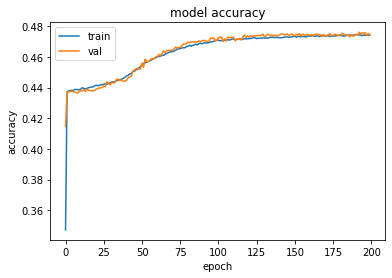

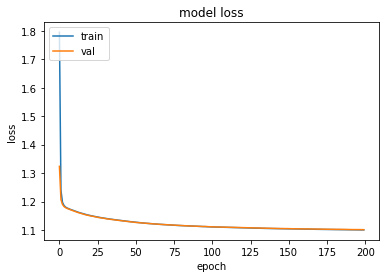

In [13]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
plt.show()

In [14]:
nn_score = model.predict(s_in)

In [15]:
test_nn_score = nn_score[test]

# sort nn_score highest to lowest
indices = test_nn_score.argsort()

# prepare for roc curve plot
best_index_asc = test_nn_score.argsort(axis=1)
best_index = best_index_asc[:,::-1]
test_mj = untagged[test]
s_test_mj = test_mj[np.arange(test_mj.shape[0])[:,None], best_index]
s_test_score = test_nn_score[np.arange(test_nn_score.shape[0])[:,None], best_index]
max_true = to_categorical(s_test_mj[:,0], num_classes = 2)
max_true = s_test_mj[:,0]
max_val = s_test_score[:,0]
fpr, tpr, thresholds = roc_curve(max_true, max_val, pos_label=1)

<Figure size 432x288 with 0 Axes>

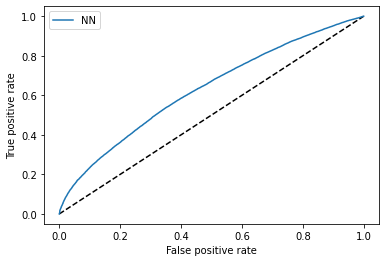

In [16]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()

A sample event

In [17]:
n_test = len(test) 

# get truth and tag arrays back
test_truth = np.array([[1, 1, 1] + list(t) for t in untagged[test]])
# all the tags were just 111000000 by construction
test_tag = np.array([[1, 1, 1] + [0]*len(t) for t in untagged[test]])

# selection_index[i] is between 0 and 7
# these correspond to picking jet 4 --> 10 or no jet ("jet 11")
selection_index = np.argmax(nn_score[test], axis=1)

# put this in a better format
selection_index += 3
selections = np.zeros_like(test_tag, dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1

# then chop off the last index so selection = [0,...,0] for no selection
test_truth = test_truth[:, :-1]
test_tag = test_tag[:, :-1]
selections = selections[:, :-1]

In [18]:

tools.evaluate_model(test_truth, test_tag, selections)


100%|██████████| 60785/60785 [00:00<00:00, 136428.72it/s]

    Total number of events: 60785
    Minus events ignored: 0, (0.00%)

    4th b-jet really exists:
        Correct 4th jet picked:         35.16%, 11960
        Incorrect 4th jet picked:       17.81%, 6060
        Event incorrectly ignored:      47.03%, 15999

    No 4th b-jet really exists:
        Correctly ignored event:        63.32%, 16949
        Incorrectly picked a 4th jet:   36.68%, 9817

    Or formatted in table form:
                    ____________________
                   |Truth-Matching      |
                   |____________________|
                   |4th exists  |No 4th |
     ______________|____________|_______|
    |4th |4th found|corr. 035.2%| 036.7%|
    |Jet |         |inco. 017.8%|       |
    |Reco|_________|____________|_______|
    |    |no 4th   |      047.0%| 063.3%|
    |____|_________|____________|_______|

    (columns add to 100% each)
    

